## This notebook provides an approach for binary classification of images specific to geophysical studies. 

The classification is based on the calculated statistical characteristics of the images and is done using a self-created neural network. 

We used:
- Cross validation technique to ensure that a model generalizes well to new data
- Grid search for the best hyperparameters selection

In [1]:
# Import of libraries
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from glob import glob
import pandas as pd
import cv2
import scipy.stats as stats
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetBinaryClassifier
%matplotlib inline

## Import images, compute statistics and associate label

In [2]:
paths_good = sorted(glob('/Crop/Good/*.png'))
paths_bad = sorted(glob('/Crop/Bad/*.png'))
print(f"There are {len(paths_good)} good images and {len(paths_bad)} bad images")

There are 100 good images and 100 bad images


In [5]:
# initialise an empty Pandas dataframe
dataset = pd.DataFrame([], columns =['Q1',
                                 'Q3',
                                 'IQR',
                                 'whisker_left',
                                 'whisker_right',
                                 'median',
                                 'mean',
                                 'std',
                                 'skewness',
                                 'kurtosis',
                                 'label',
                                 'img_path']) # to save the image path (for visualisation)

# image paths
image_paths = paths_good + paths_bad

# labels: good = 1 and bad = 0
good_labels = np.full(100, 1)
bad_labels = np.full(100, 0)
labels = np.concatenate((good_labels, bad_labels))

# load images and compute statistics
for img_path, label in zip(image_paths, labels):

    
    # load raw cropped images in gray scale, and replace 255 by nan
    img_array = cv2.imread(img_path, 0)
    img_array = np.where(img_array == 255, np.nan, img_array)

    
    # compute statistics
    Q1, Q3 = np.nanpercentile(img_array, [25,75])
    
    IQR = Q3 - Q1
    whisker_left = Q1 - 1.5*IQR
    whisker_right = Q3 + 1.5*IQR
    
    median = np.nanmedian(img_array)
    
    mean = np.nanmean(img_array)
    
    std = np.nanstd(img_array)

    
    #Filter statistics on the not nan values and compute skewness and kurtosys
    img_notnull = img_array[~np.isnan(img_array)]
    skewness = stats.skew(img_notnull.ravel())
    kurtosis = stats.kurtosis(img_notnull.ravel())

    
    dataset = dataset.append({'Q1': Q1,
                              'Q3': Q3,
                              'IQR': IQR,
                              'whisker_left': whisker_left,
                              'whisker_right': whisker_right,
                              'median': median,
                              'mean': mean,
                              'std': std,
                              'skewness': skewness,
                              'kurtosis': kurtosis,
                              'label': label,
                              'img_path': img_path}, ignore_index = True)


/var/folders/zb/89pd92lx5wd87rvb47xh9jt00000gn/T/ipykernel_5221/3781247210.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'Q1': Q1,
/var/folders/zb/89pd92lx5wd87rvb47xh9jt00000gn/T/ipykernel_5221/3781247210.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'Q1': Q1,
/var/folders/zb/89pd92lx5wd87rvb47xh9jt00000gn/T/ipykernel_5221/3781247210.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'Q1': Q1,
/var/folders/zb/89pd92lx5wd87rvb47xh9jt00000gn/T/ipykernel_5221/3781247210.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append

# Prepare data for training
#### Split the data into train and test datasets
***
We'll use a test/validation set with 60 images (30% of the dataset). To ensure we get the same set each time, we'll set the random number generator to a seed value of 43.

In [7]:
# Sample 70% of the data in the dimension on the row for the train dataset
data_train = dataset.sample(frac=0.7, axis=0, random_state=43) 

# Use the remaining part of the data for the test dataset
data_test  = dataset.drop(data_train.index) 

#Remove the output data and the image path
x_train = data_train.drop(['label', 'img_path'],  axis=1) 

#Put the output data in dedicated variable
y_train = data_train['label'] 
x_test  = data_test.drop(['label', 'img_path'],   axis=1)
y_test  = data_test['label']

# Store the image path for test visualisation
img_path_test = data_test['img_path'] 

print('Original data shape was : ',dataset.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
print('img_path_test  : ',img_path_test.shape)

Original data shape was :  (200, 12)
x_train :  (140, 10) y_train :  (140,)
x_test  :  (60, 10) y_test  :  (60,)
img_path_test  :  (60,)


#### Data normalization
***
- All input data must be normalized, train and test.  
- To do this we will subtract the mean and divide by the standard deviation.  
- But test data should not be used in any way, even for normalization.  
- The mean and the standard deviation will therefore only be calculated with the train data.

In [8]:
mean = x_train.mean()
std  = x_train.std()

x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

x_train, y_train = np.array(x_train, dtype='float32'), np.array(y_train, dtype='float32')
x_test,  y_test  = np.array(x_test, dtype='float32'),  np.array(y_test, dtype='float32')

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(140, 10) (140,) (60, 10) (60,)


# Build a neural network model

In [9]:
class model_v1(nn.Module):
    def __init__(self, num_vars):
        """this method is used to define the model's layers"""
        super(model_v1, self).__init__()
        self.num_vars=num_vars
        
        # define layers
        self.hidden1 = nn.Linear(self.num_vars,32)
        self.hidden2 = nn.Linear(32,64)
        self.hidden3 = nn.Linear(64,1)
        
    def forward(self, x):
        #flatten the observation before using fully-connected layers
        x = x.view(-1,self.num_vars)   
        # Apply layers & activation functions
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.hidden3(x)
        return x


# Train our neural network model, cross-validate and find its best hyperparameters
#### Instanciate the model
***

In [10]:
# create the skorch wrapper for grid search (to make pytorch compatible with scikit-learn)

model = NeuralNetBinaryClassifier(module = model_v1(x_train[0,:].shape[0]),
                                  optimizer = torch.optim.SGD)
                                  

#### Choice of number of folds k for cross-validation
***

In [11]:
k = 10

#### Train and Grid search for best hyperparameters selection
***

In [12]:
# Define the hyperparameter grid (replace with desired hyperparameter names and values)
param_grid = {
    'max_epochs': [5, 10, 15],  # Fewer epochs for small dataset
    'lr': [0.0001, 0.001, 0.01],  # Lower learning rates
    'batch_size': [4, 8, 16, 32],  # Smaller batch sizes
}

# Create the GridSearchCV object with our model class and scoring function
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=k, refit=True, error_score='raise')

# Fit the GridSearchCV object with training data
grid_search.fit(x_train, y_train)

# Access the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\n\n\nBest Hyperparameters:", best_params)
print("Best Model:", best_model)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6864       0.5385        0.6834  0.1062
      2        0.6863       0.5385        0.6834  0.0152
      3        0.6863       0.5385        0.6834  0.0146
      4        0.6862       0.5385        0.6833  0.0158
      5        0.6862       0.5385        0.6833  0.0144
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6864       0.3462        0.6865  0.0147
      2        0.6863       0.3462        0.6864  0.0150
      3        0.6863       0.3462        0.6864  0.0150
      4        0.6862       0.3462        0.6864  0.0144
      5        0.6862       0.3462        0.6863  0.0153
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6865       0.5769        0.6776  0.0148
      2        0.6865       0.5

# Test the best model
#### Predicted labels for test data set
***

In [13]:
y_test_pred = best_model.predict(x_test)
y_test_pred

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

#### Predictions confidence [bad, good]
***

In [14]:
confidence = best_model.predict_proba(x_test)
confidence

array([[0.5014564 , 0.49854365],
       [0.5033823 , 0.4966177 ],
       [0.5062425 , 0.4937575 ],
       [0.5045825 , 0.49541748],
       [0.499254  , 0.500746  ],
       [0.50511026, 0.4948897 ],
       [0.5051772 , 0.4948228 ],
       [0.49826032, 0.5017397 ],
       [0.46334475, 0.53665525],
       [0.45929956, 0.54070044],
       [0.46302062, 0.5369794 ],
       [0.43342972, 0.5665703 ],
       [0.475016  , 0.524984  ],
       [0.4478147 , 0.5521853 ],
       [0.4816962 , 0.5183038 ],
       [0.48531324, 0.51468676],
       [0.5036943 , 0.49630567],
       [0.4698332 , 0.5301668 ],
       [0.4671076 , 0.5328924 ],
       [0.47512388, 0.5248761 ],
       [0.42240298, 0.577597  ],
       [0.45852757, 0.54147243],
       [0.45210928, 0.5478907 ],
       [0.46123153, 0.5387685 ],
       [0.45877278, 0.5412272 ],
       [0.45008415, 0.54991585],
       [0.49420804, 0.50579196],
       [0.4924897 , 0.5075103 ],
       [0.500931  , 0.49906898],
       [0.4948905 , 0.5051095 ],
       [0.

#### Overall Quality Metrics
***

In [15]:
accuracy = best_model.score(x_test, y_test)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7
Precision: 0.696969696969697
Recall: 0.7419354838709677
F1 Score: 0.71875


#### Total Confusion Matrix
***

In [16]:
confusion = confusion_matrix(y_test, y_test_pred)
confusion = pd.DataFrame(confusion)
confusion

0   1
0  19  10
1   8  23

#### Results visualisation
***

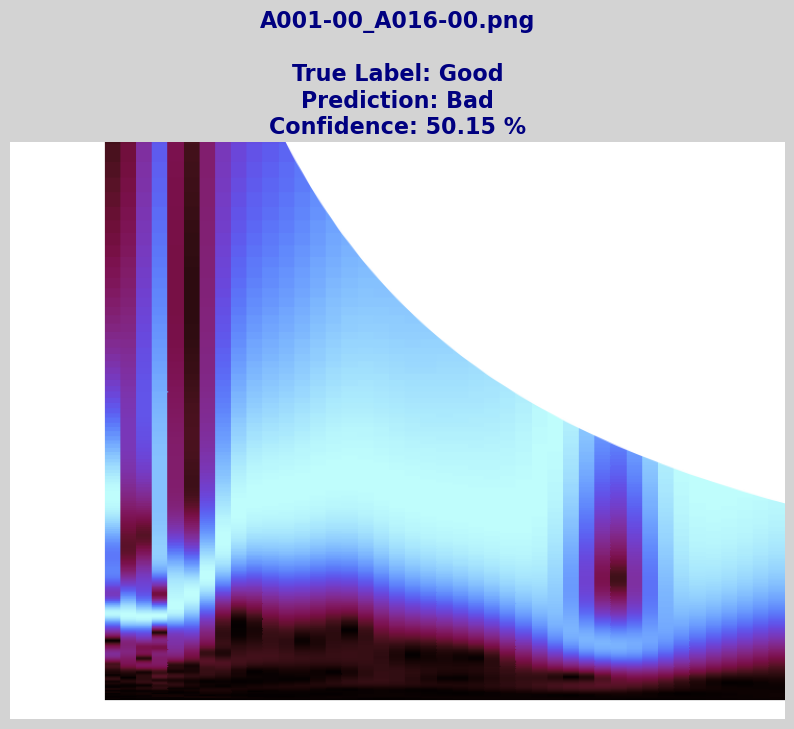

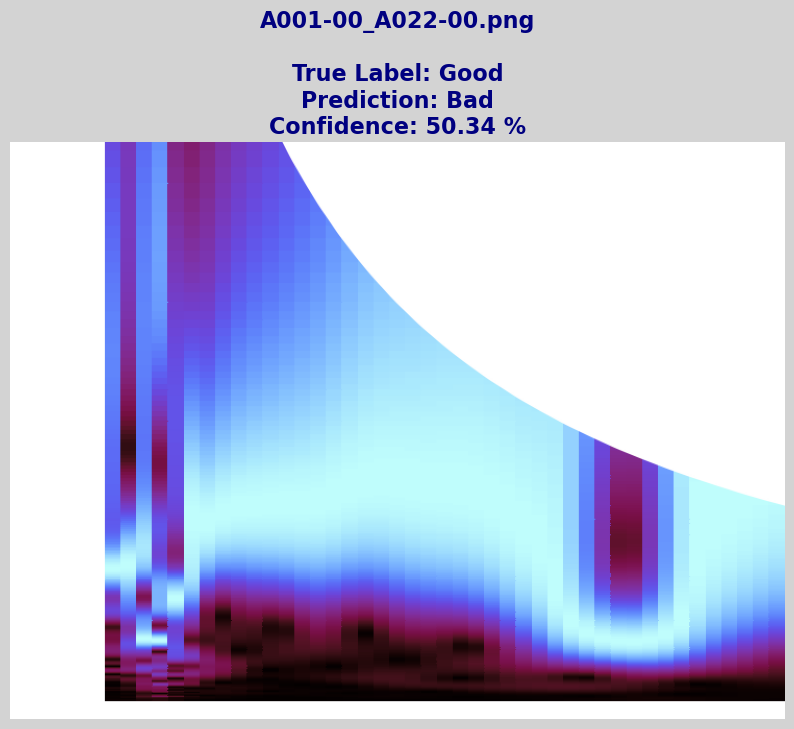

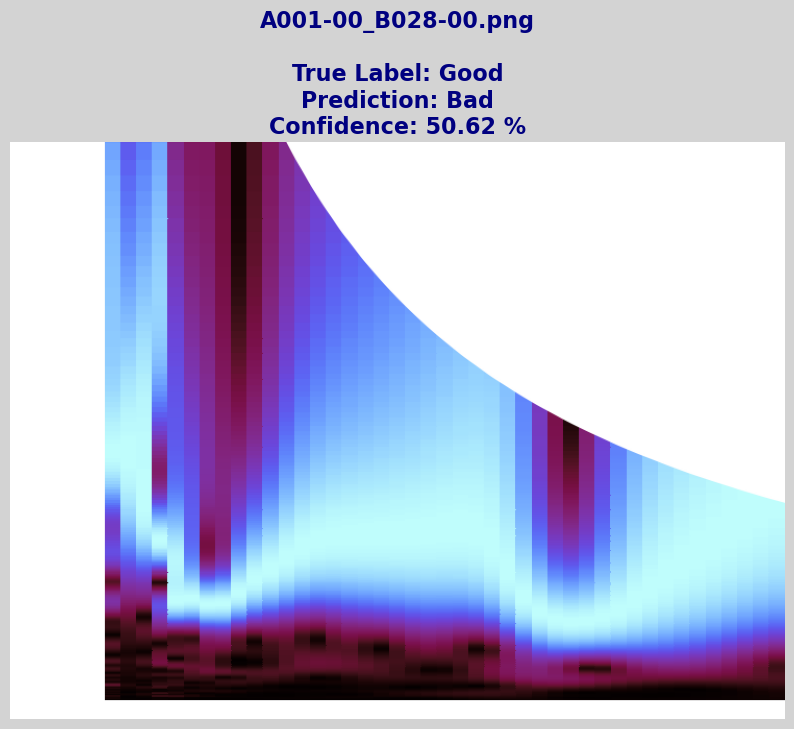

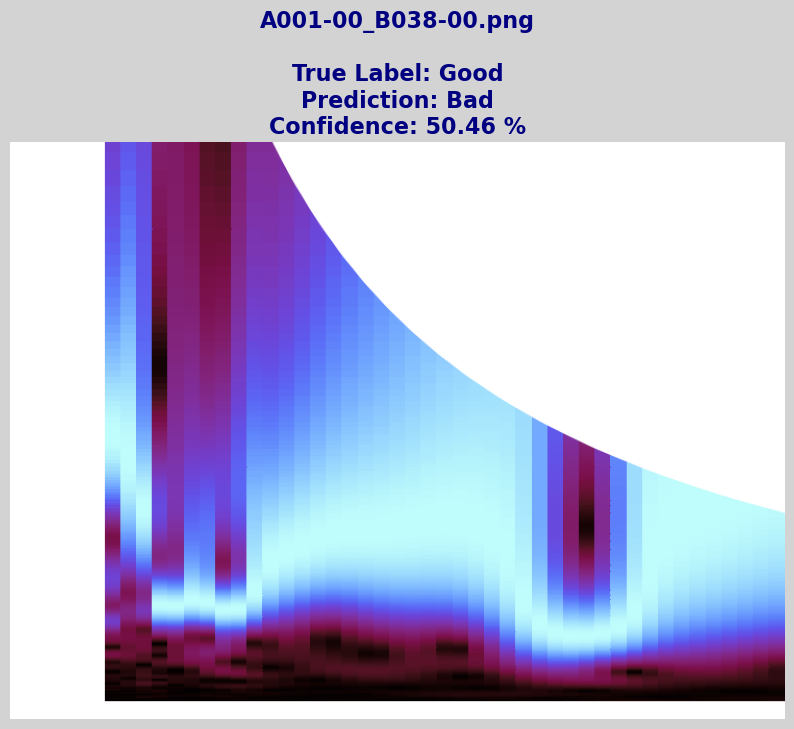

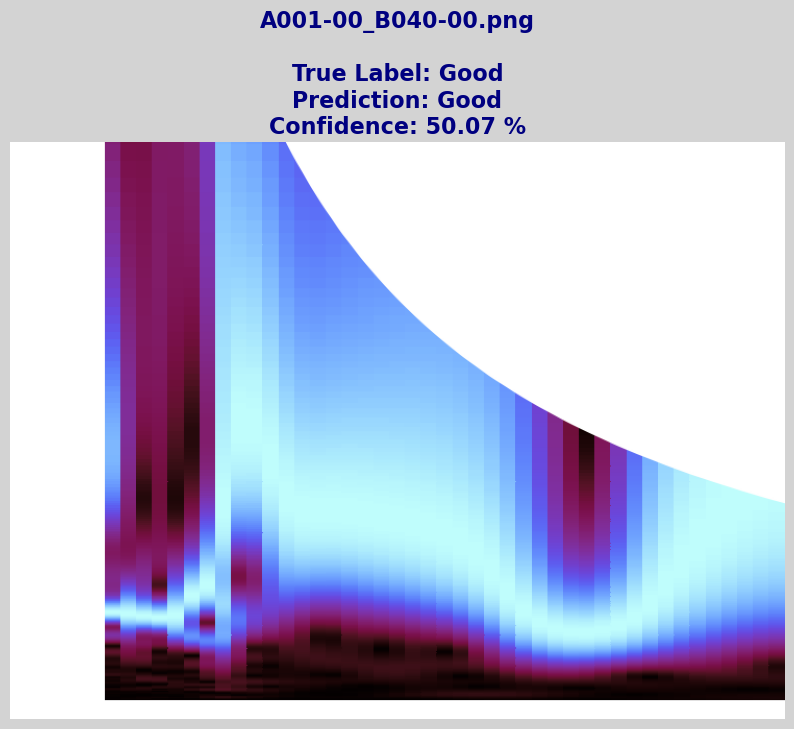

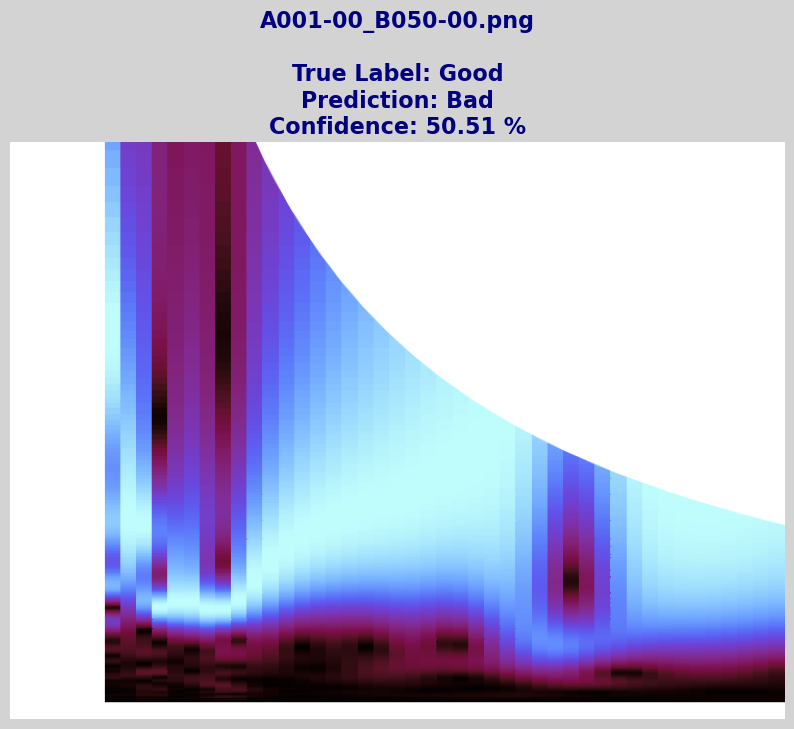

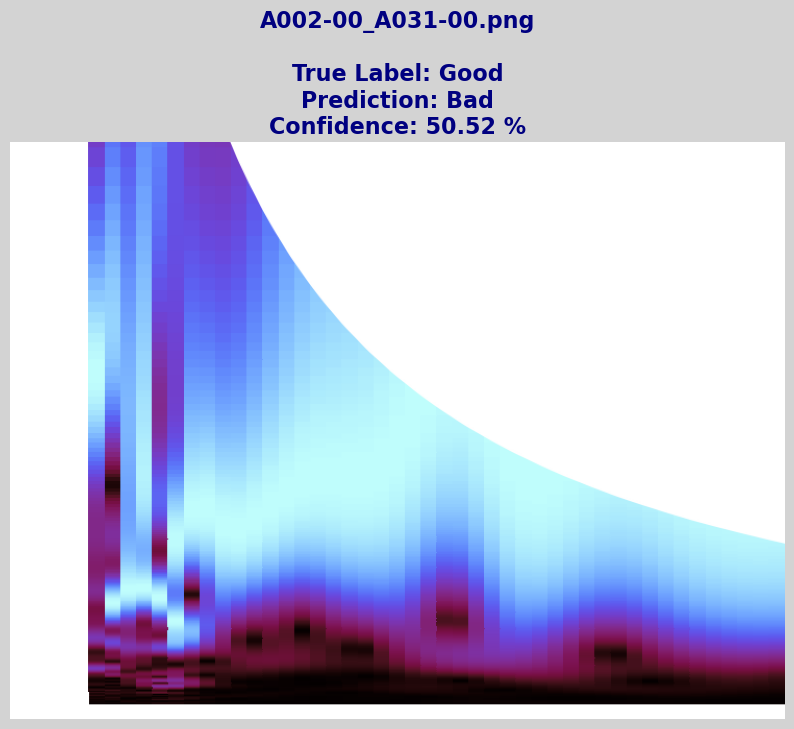

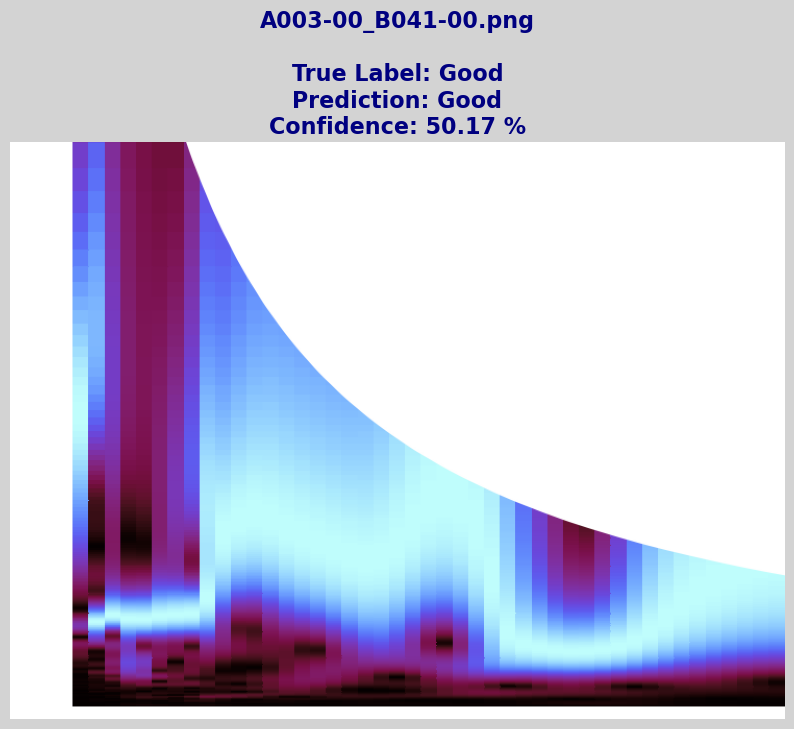

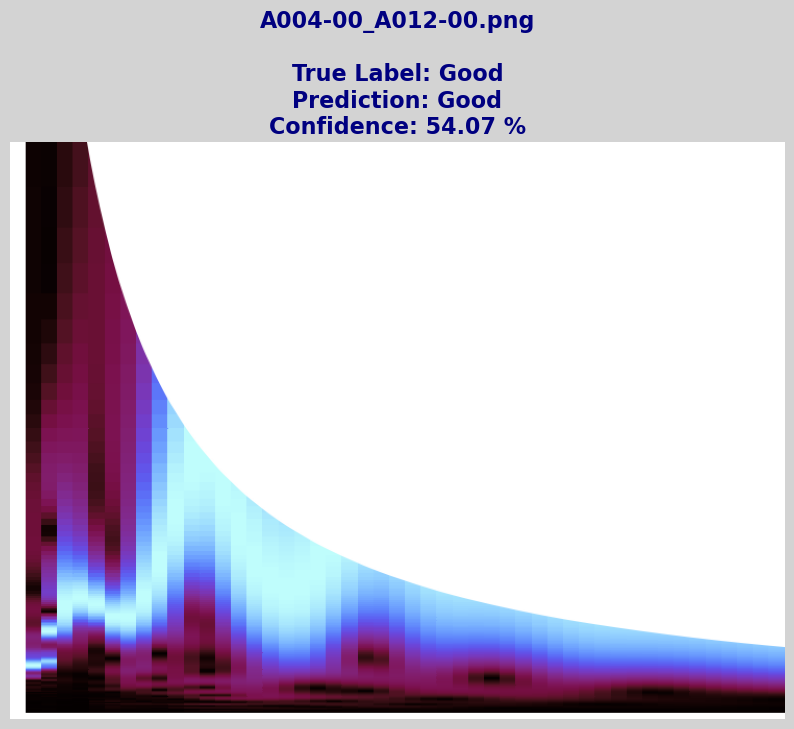

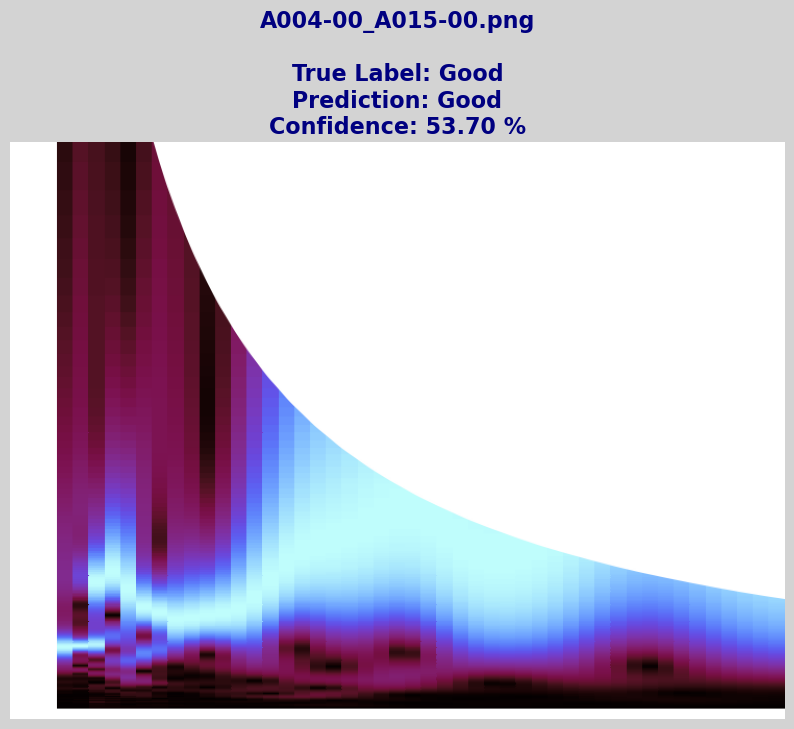

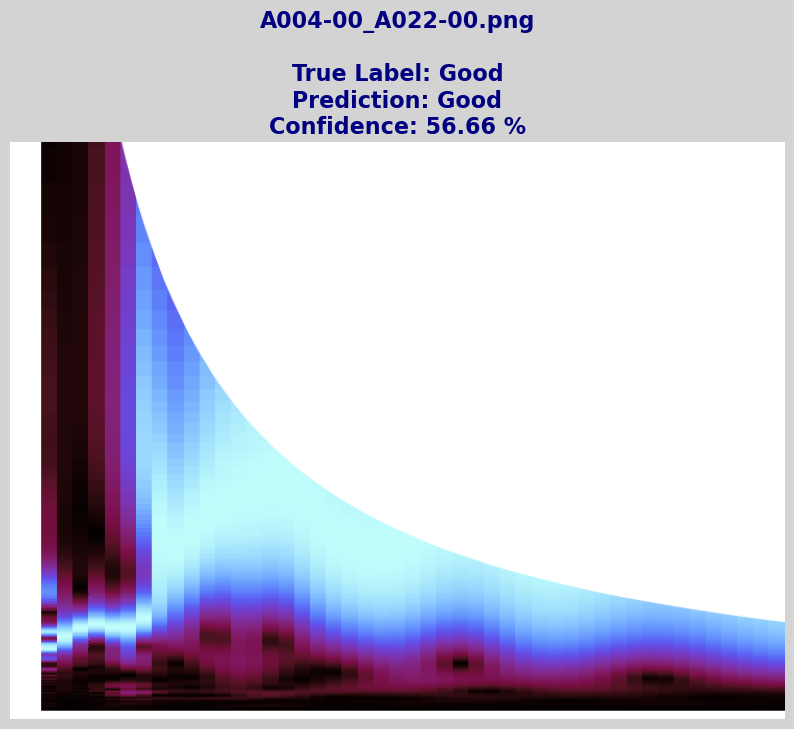

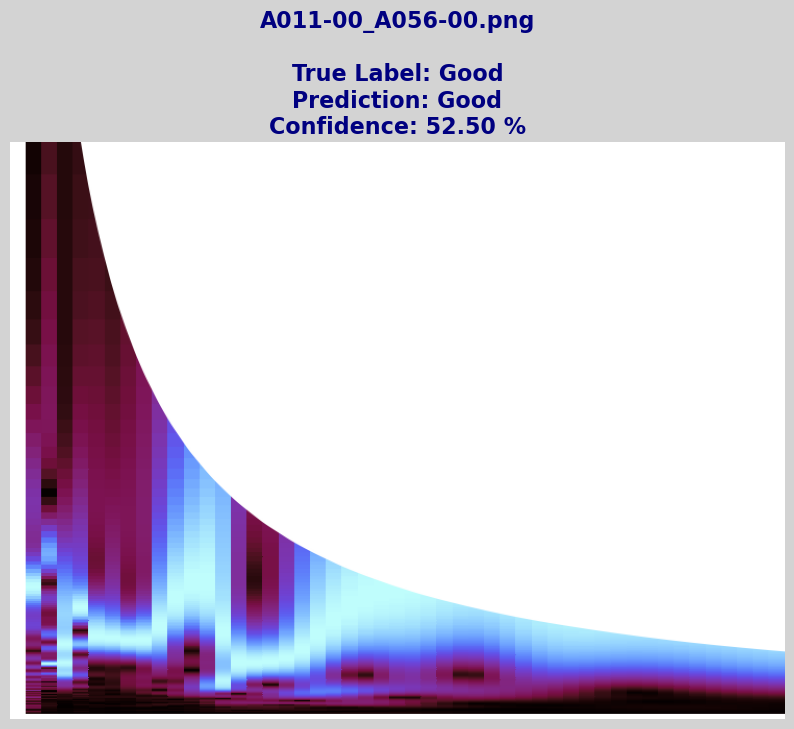

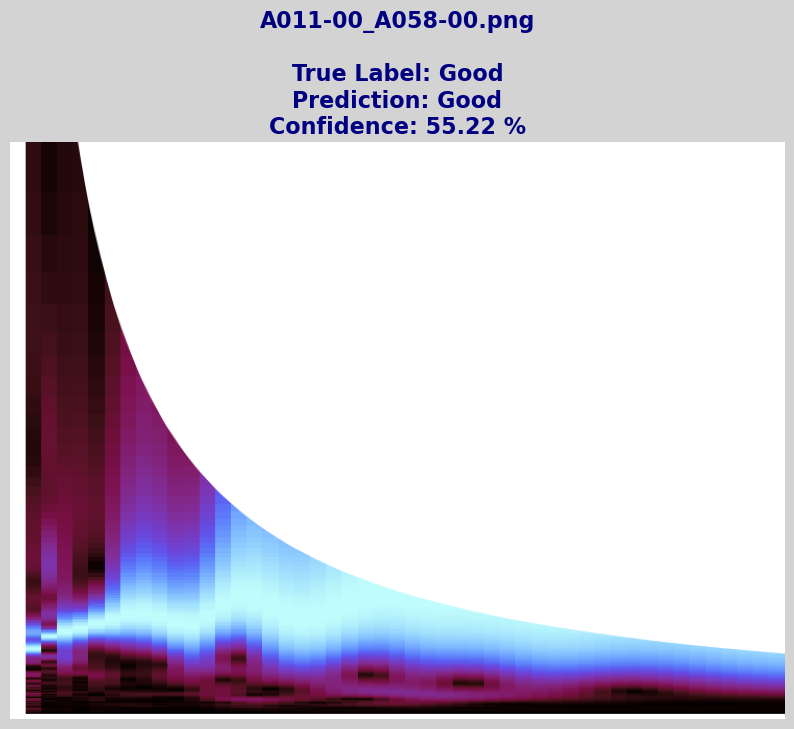

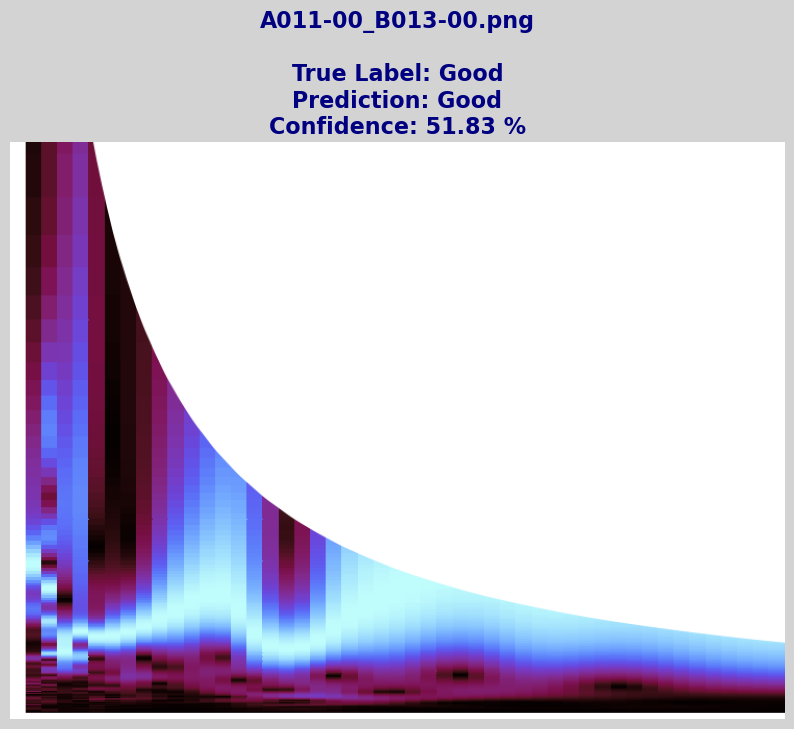

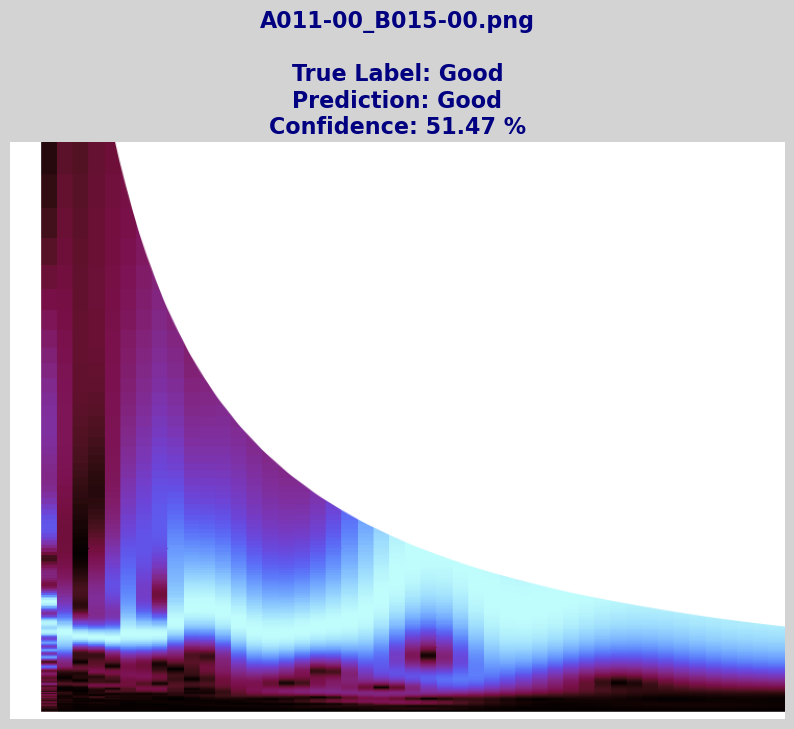

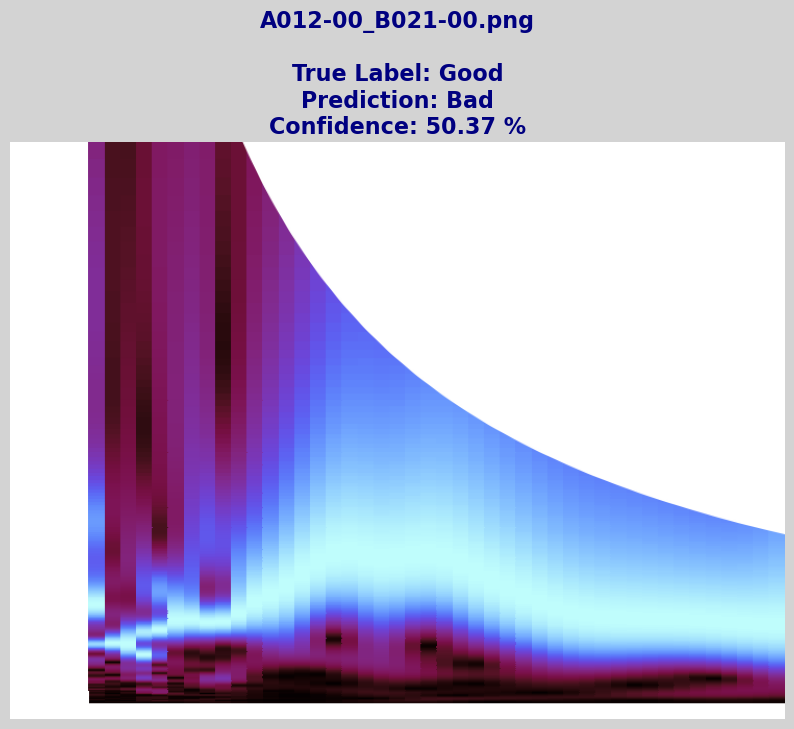

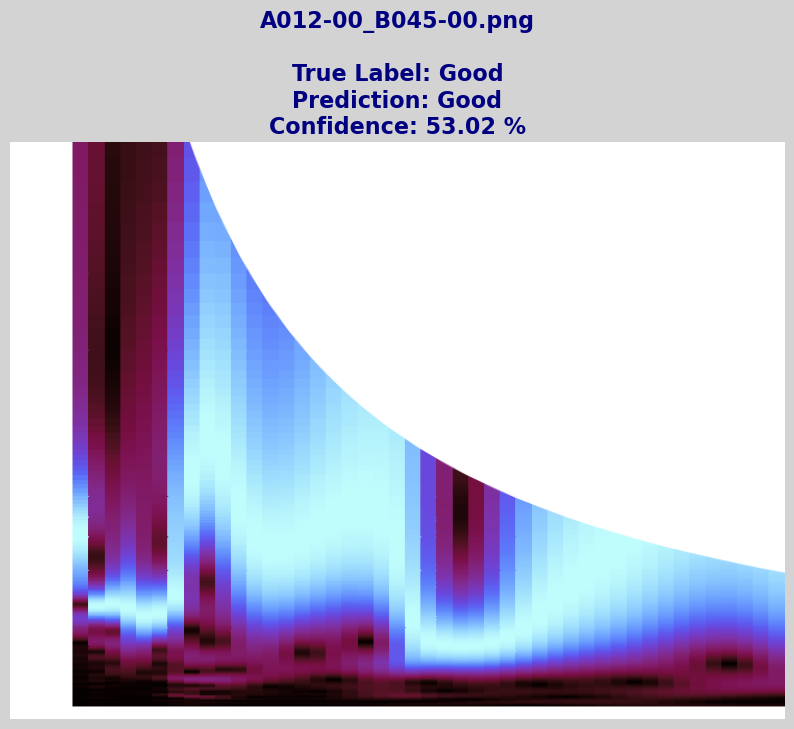

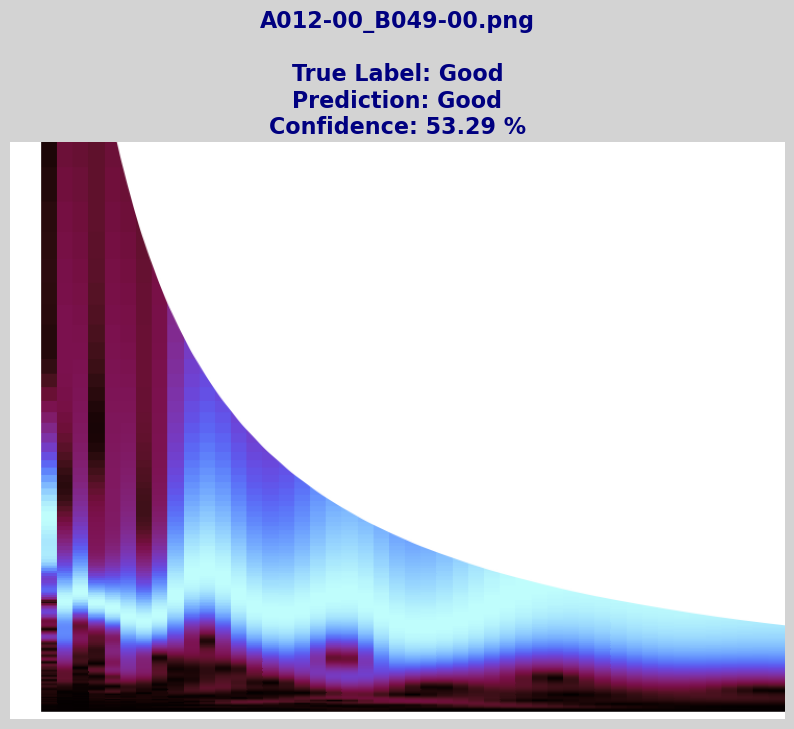

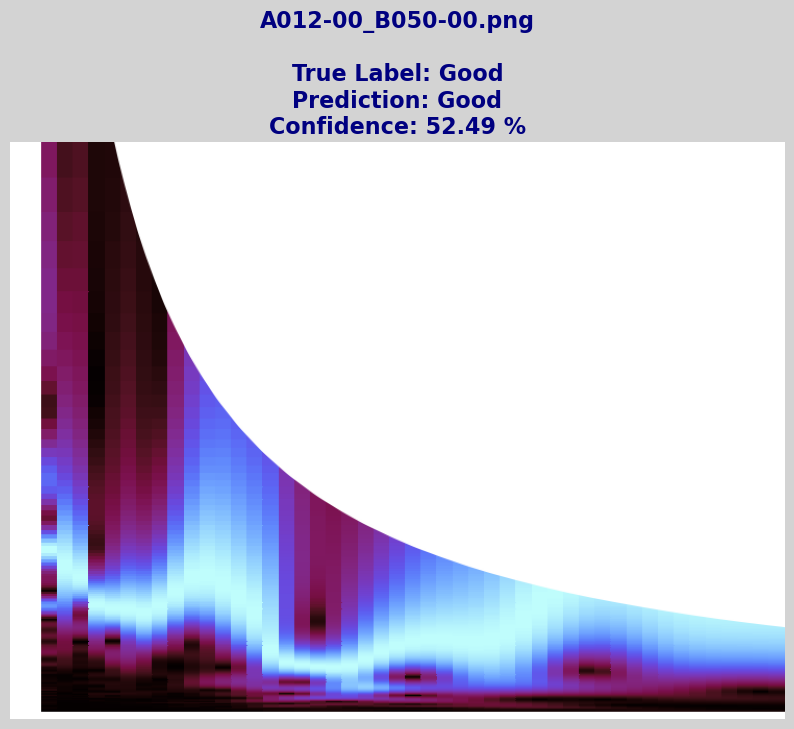

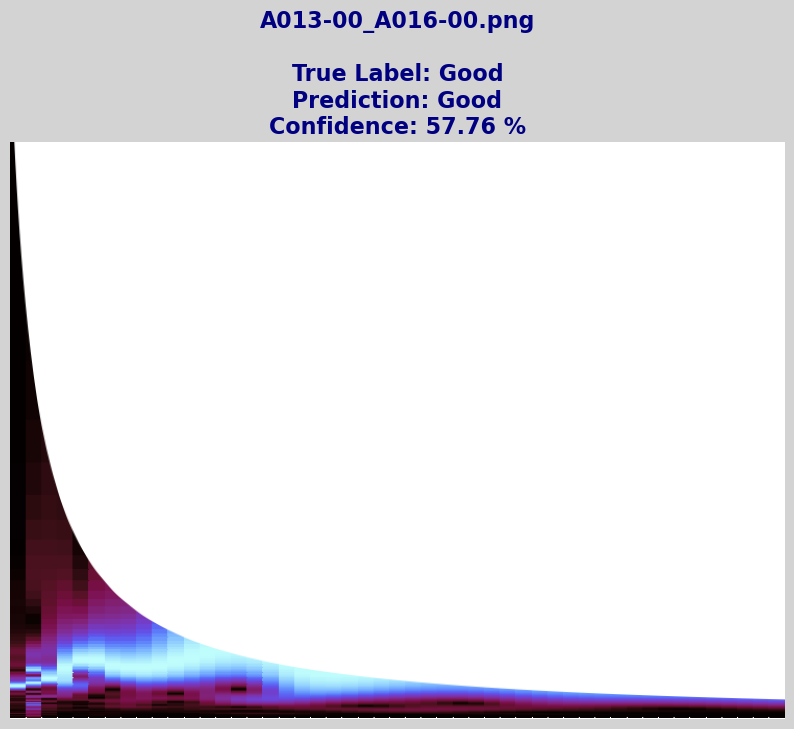

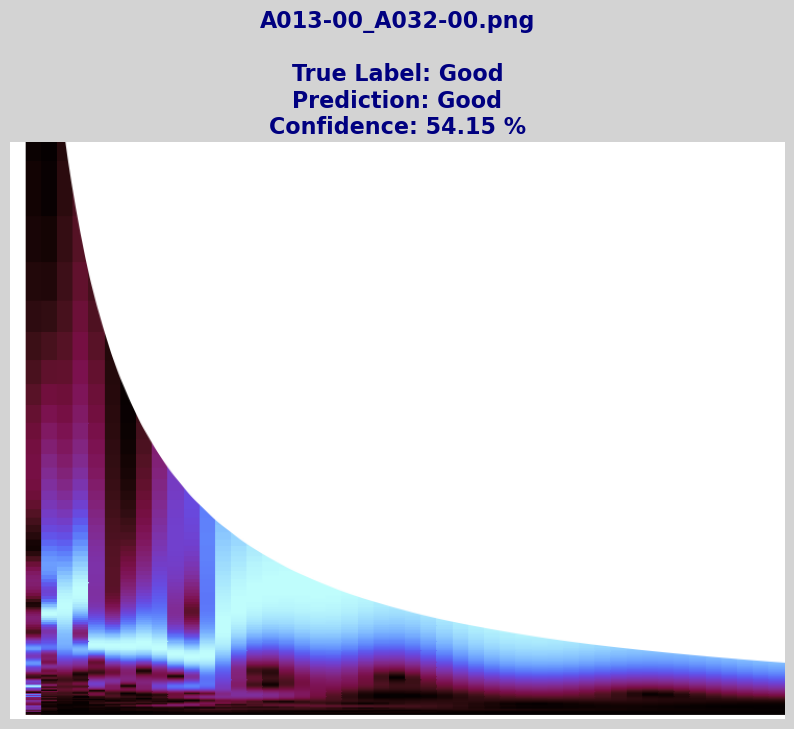

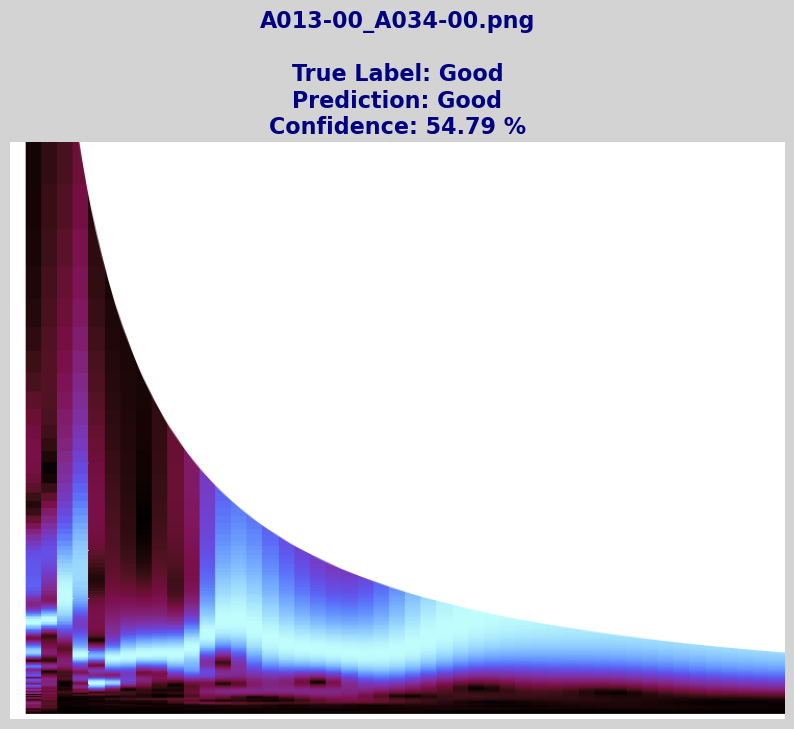

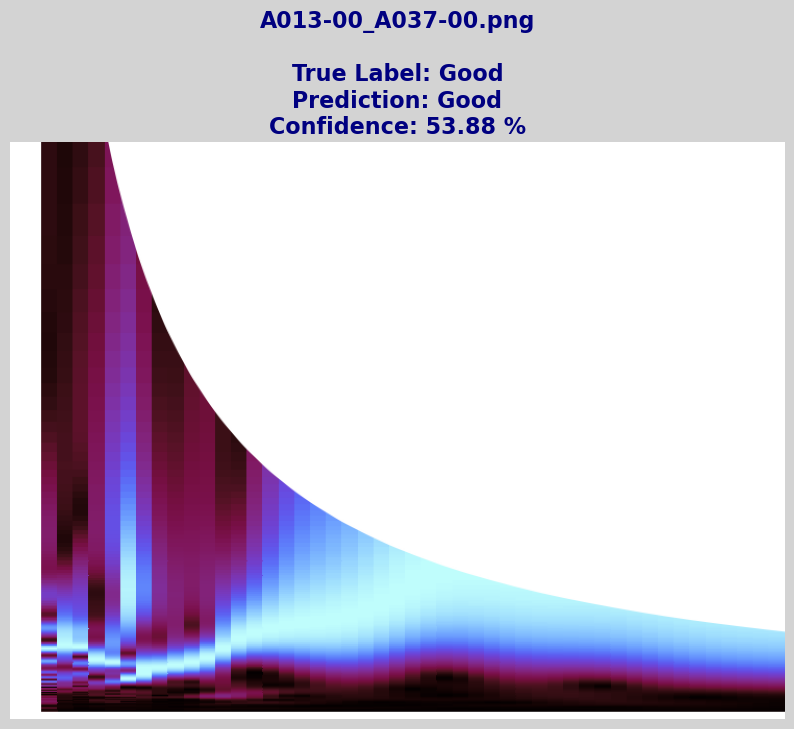

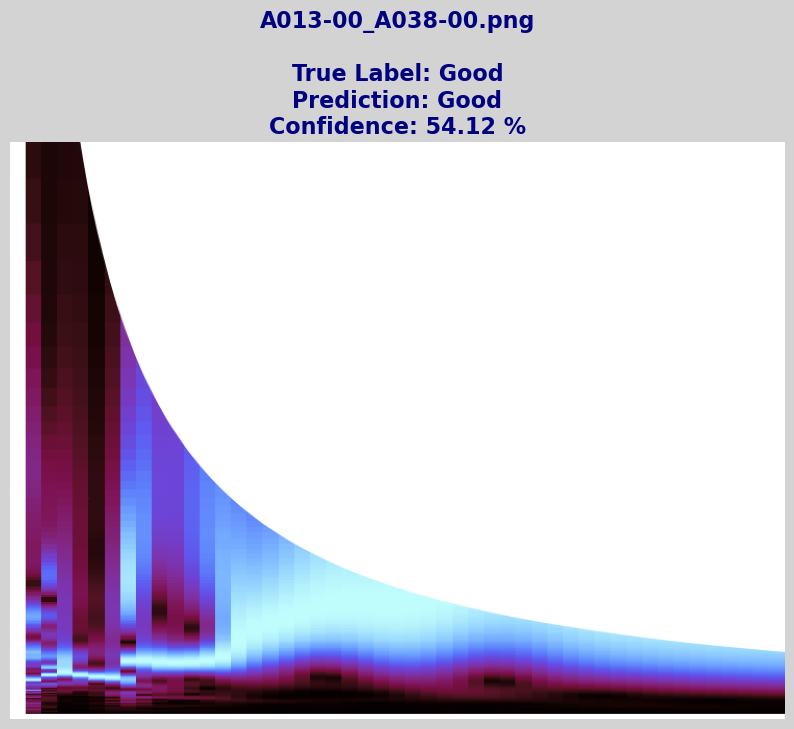

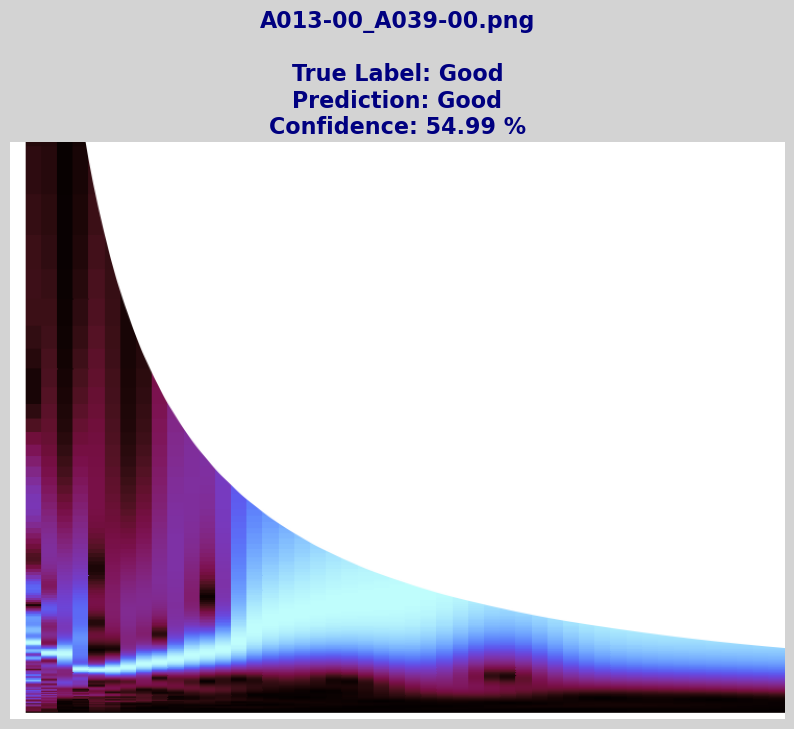

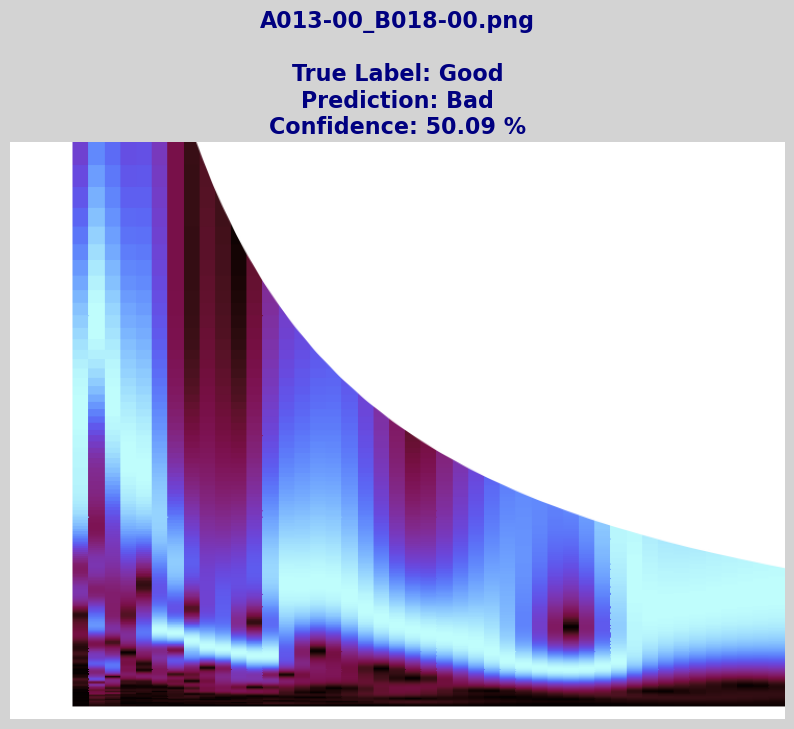

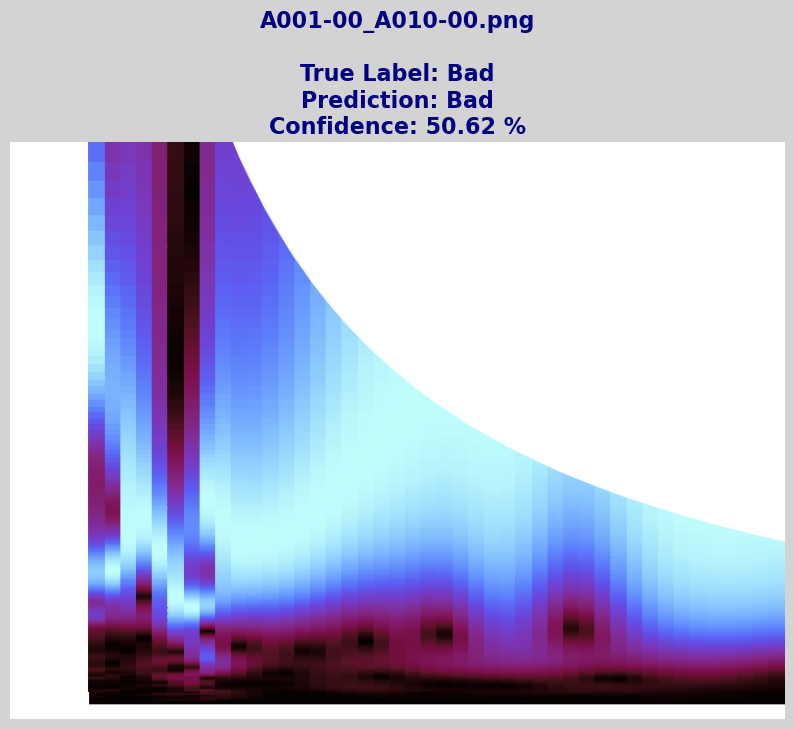

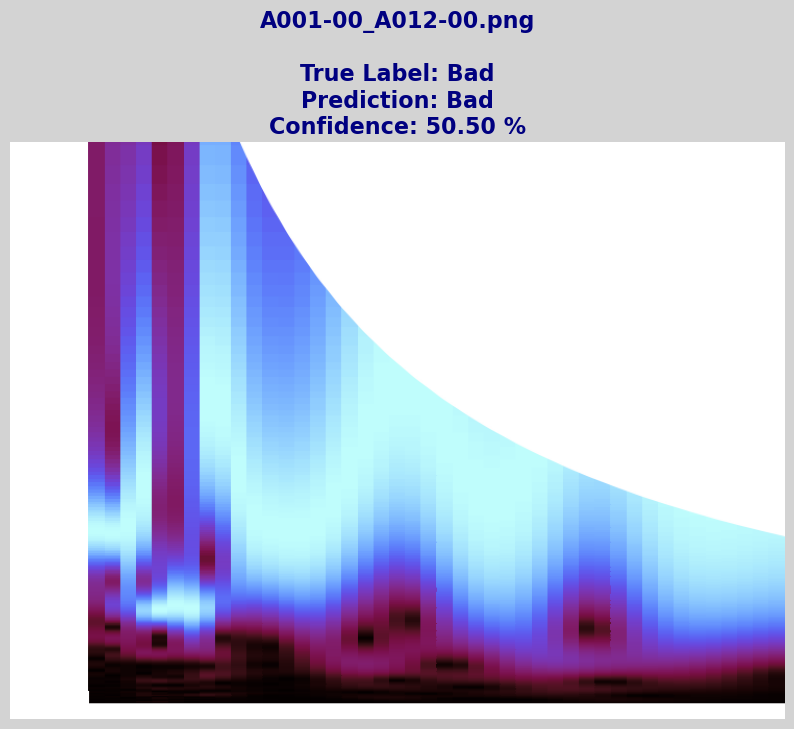

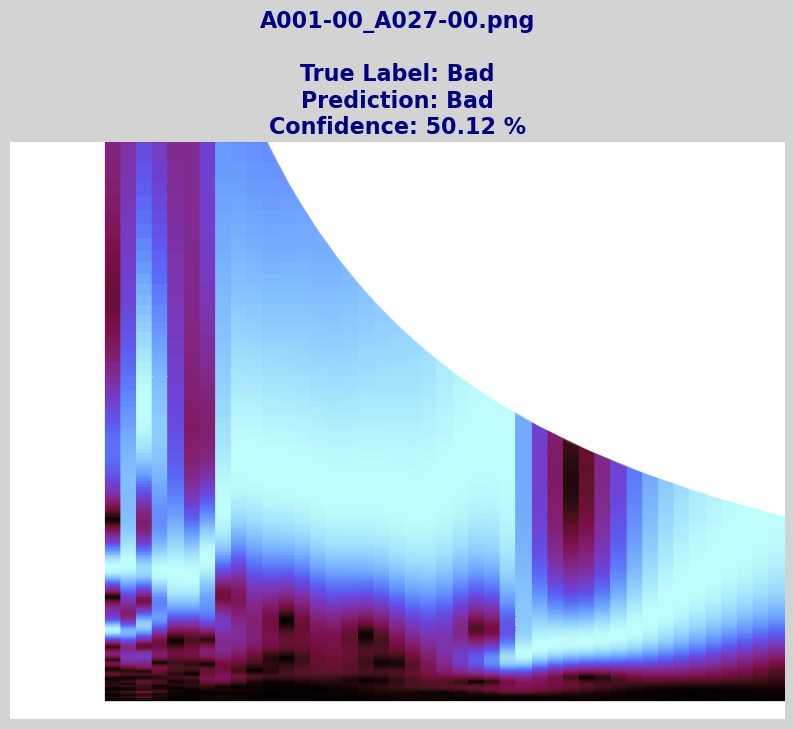

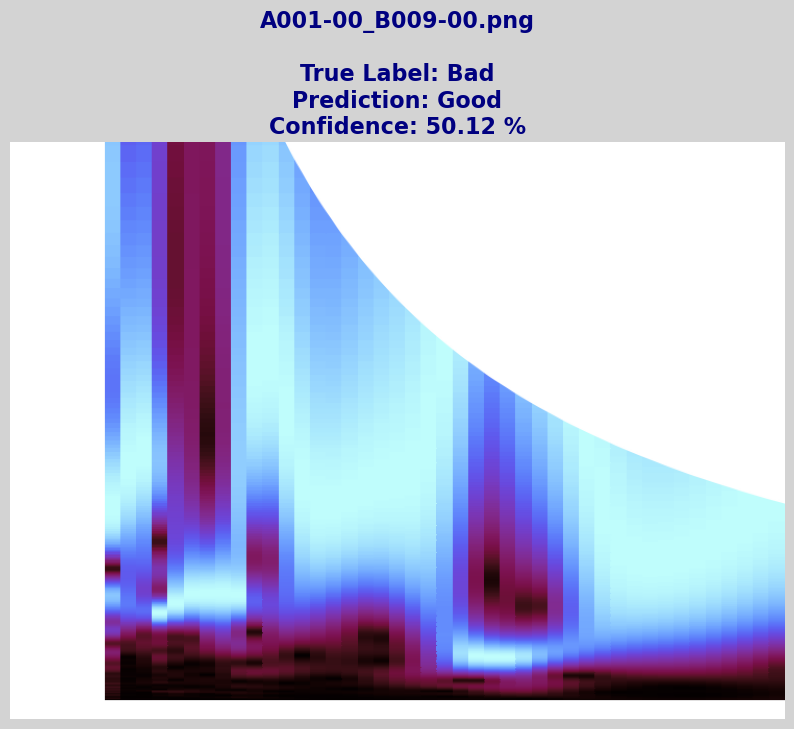

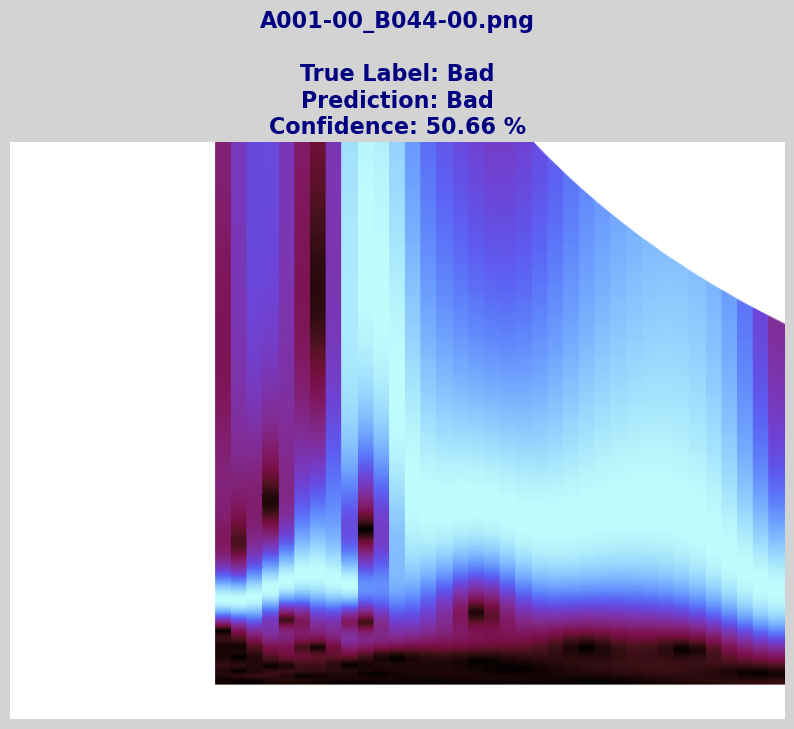

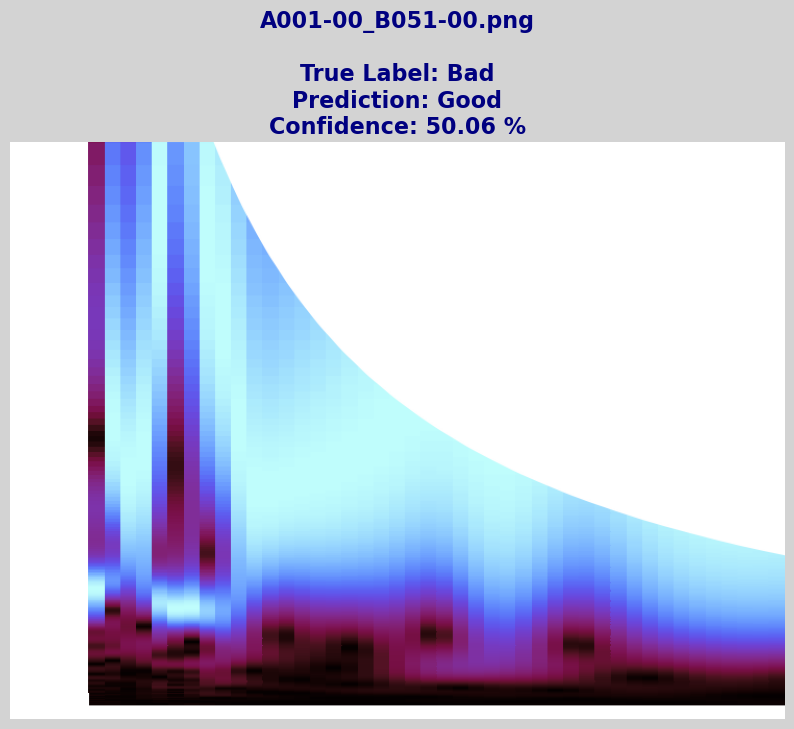

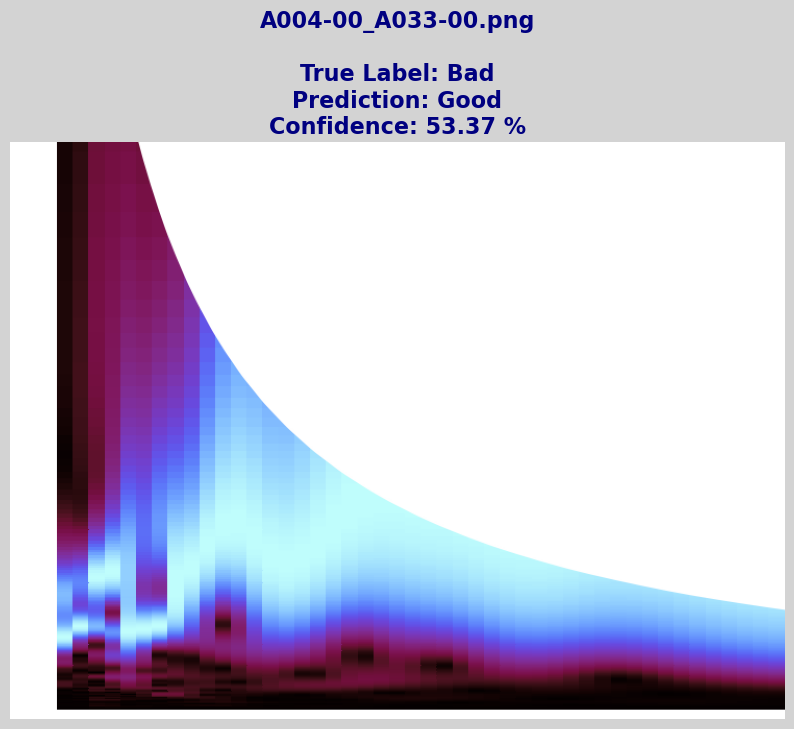

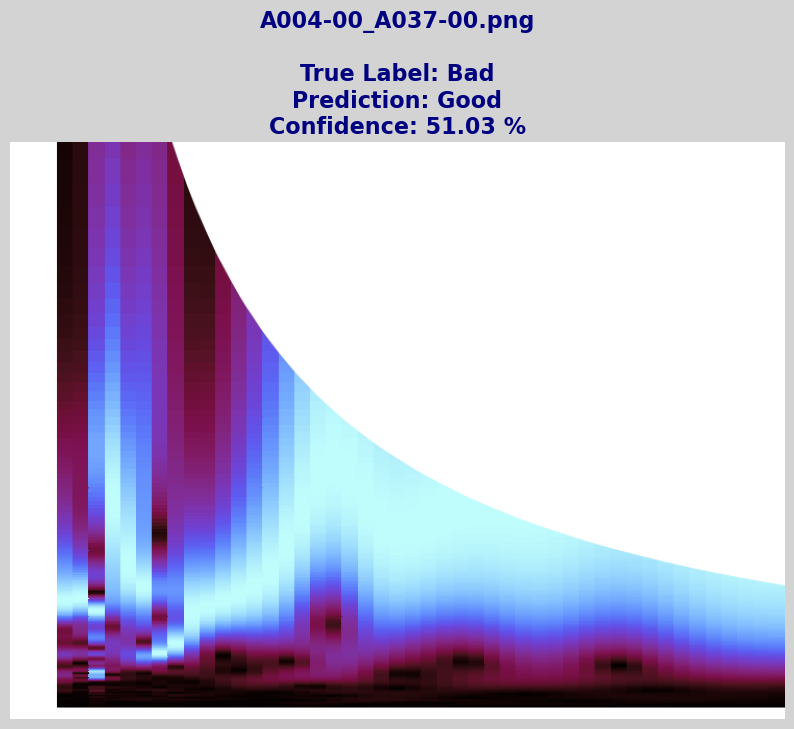

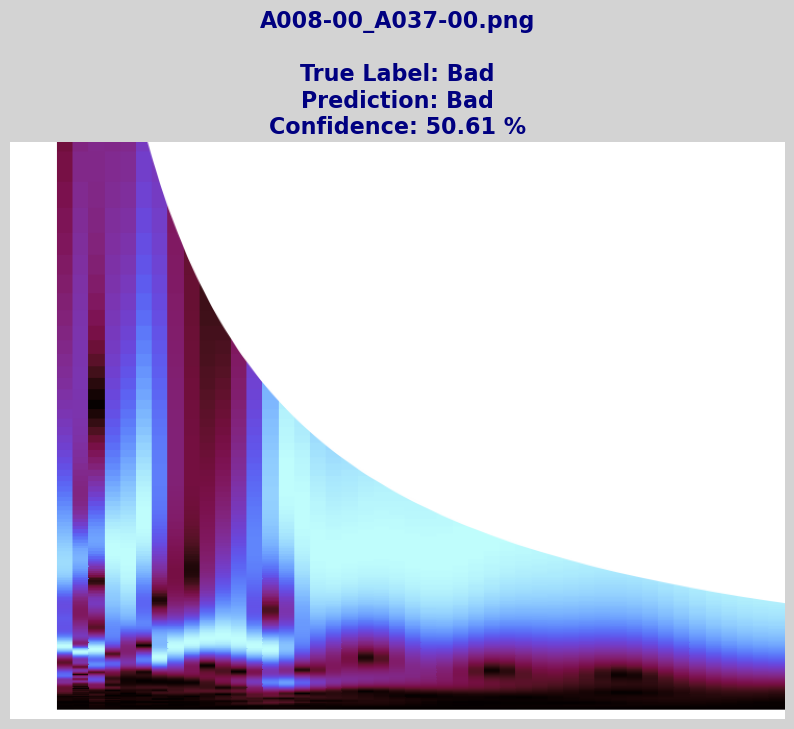

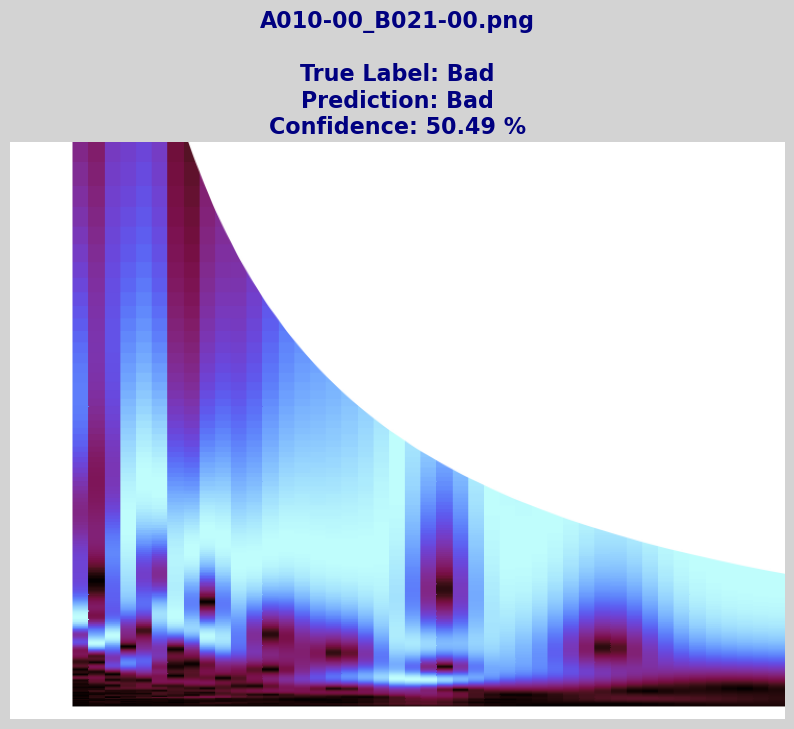

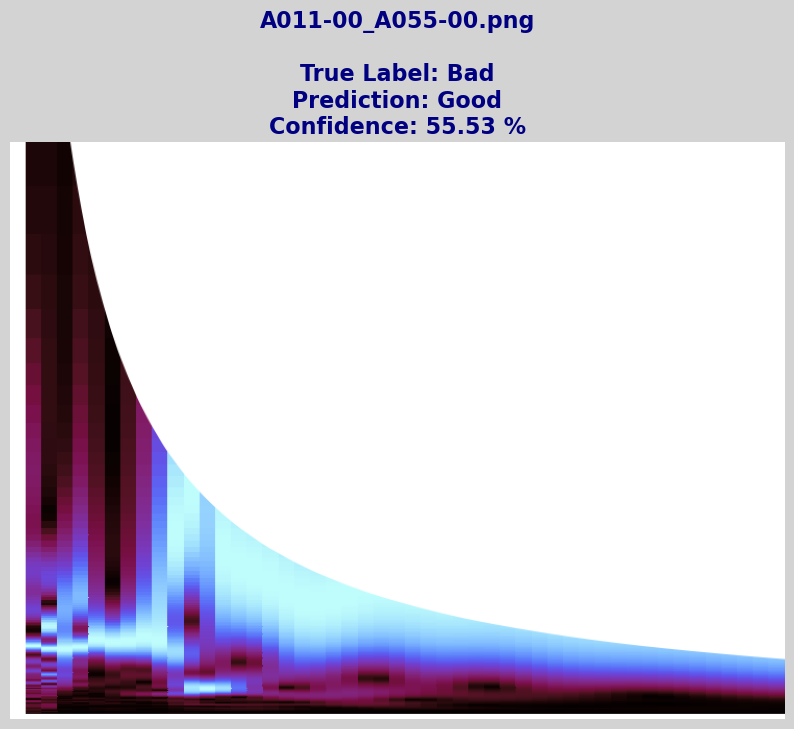

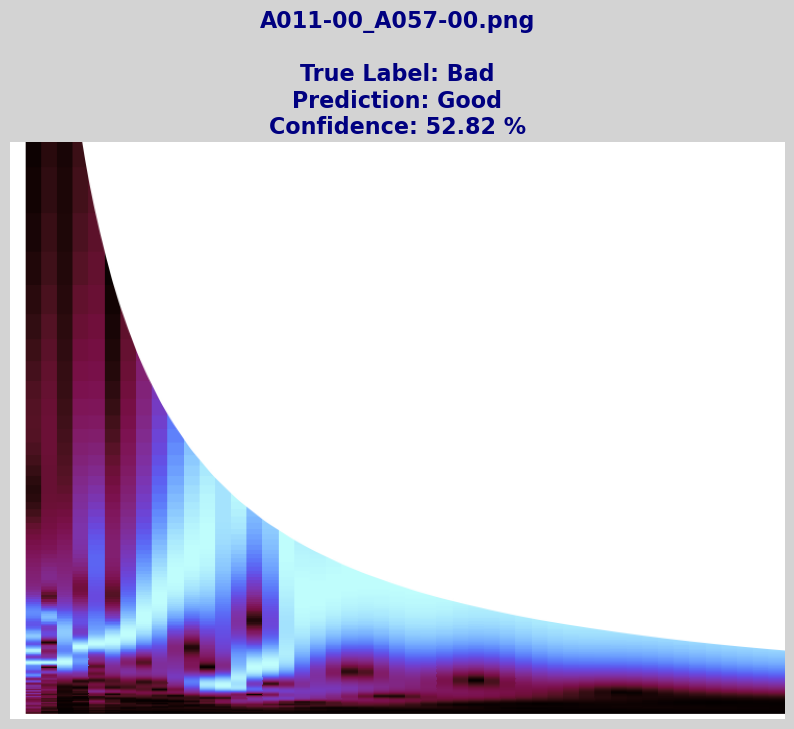

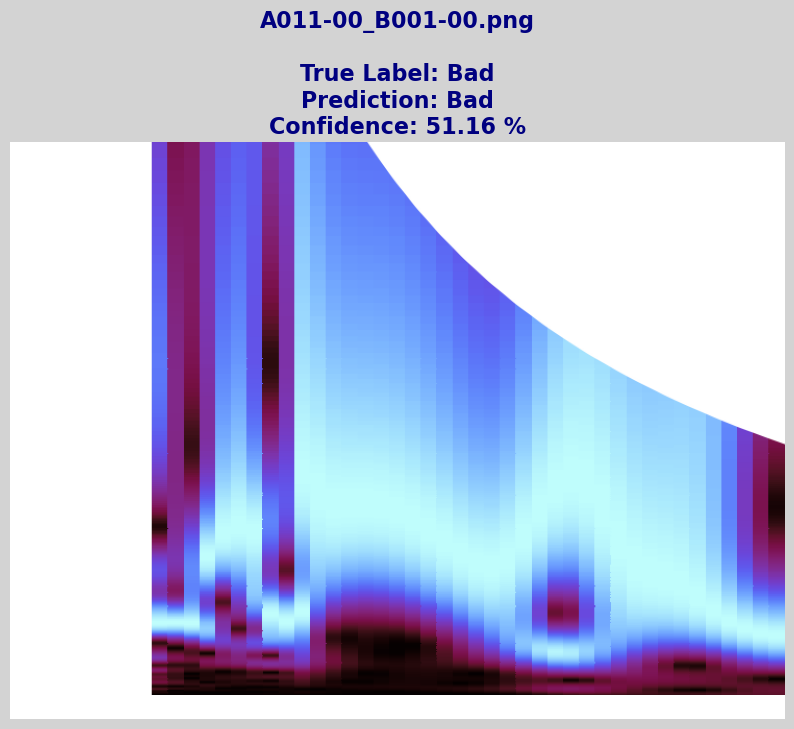

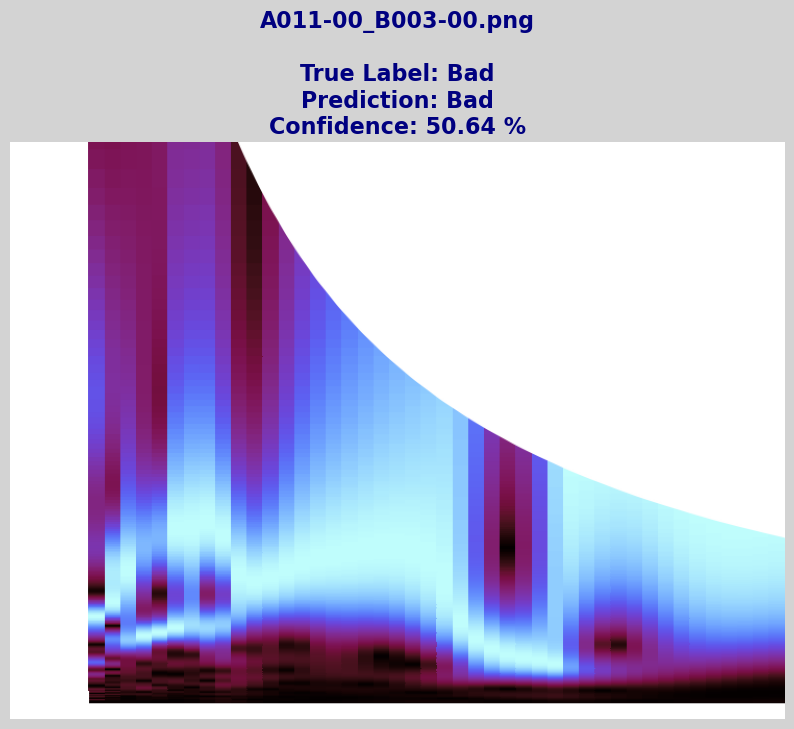

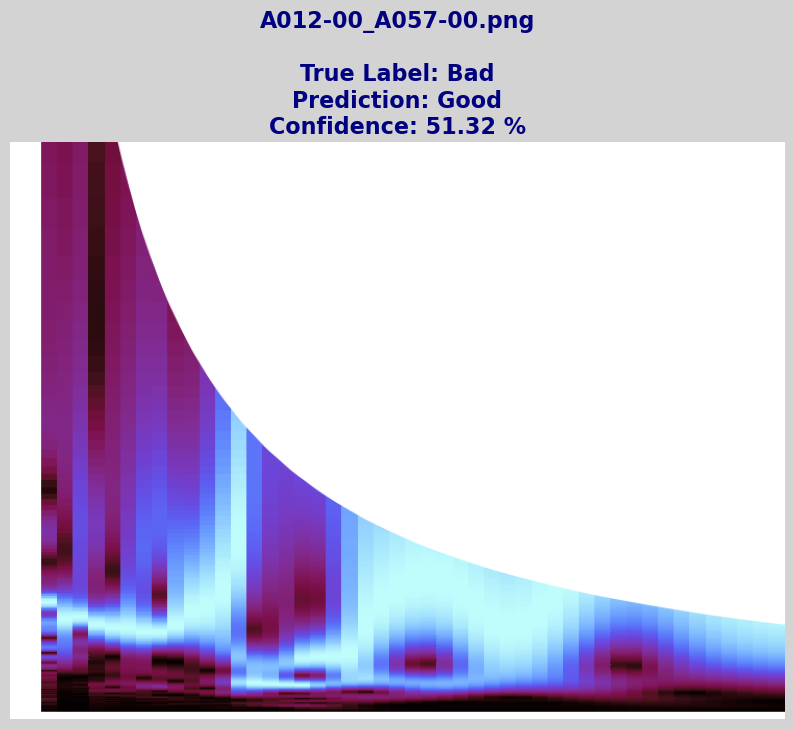

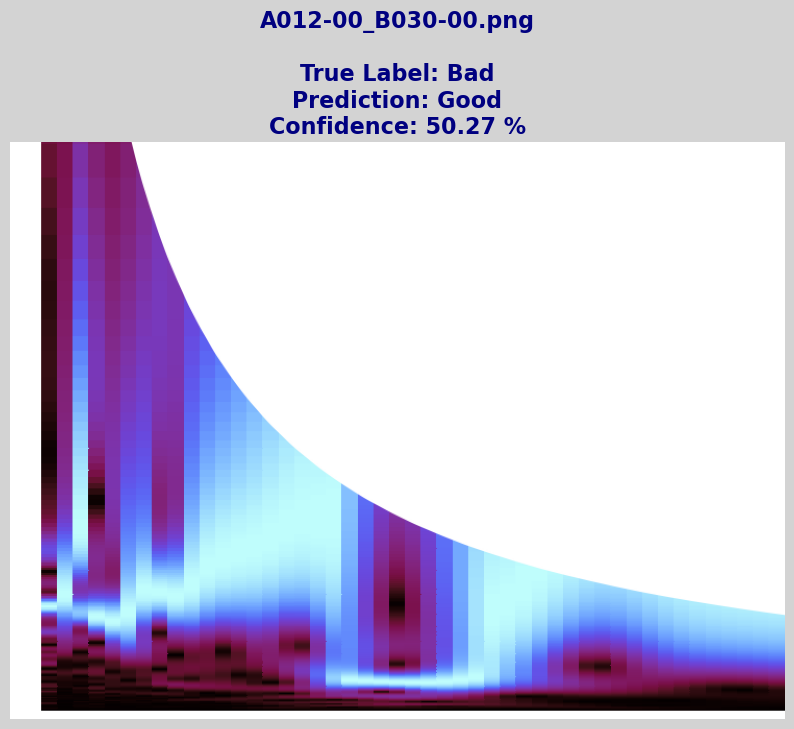

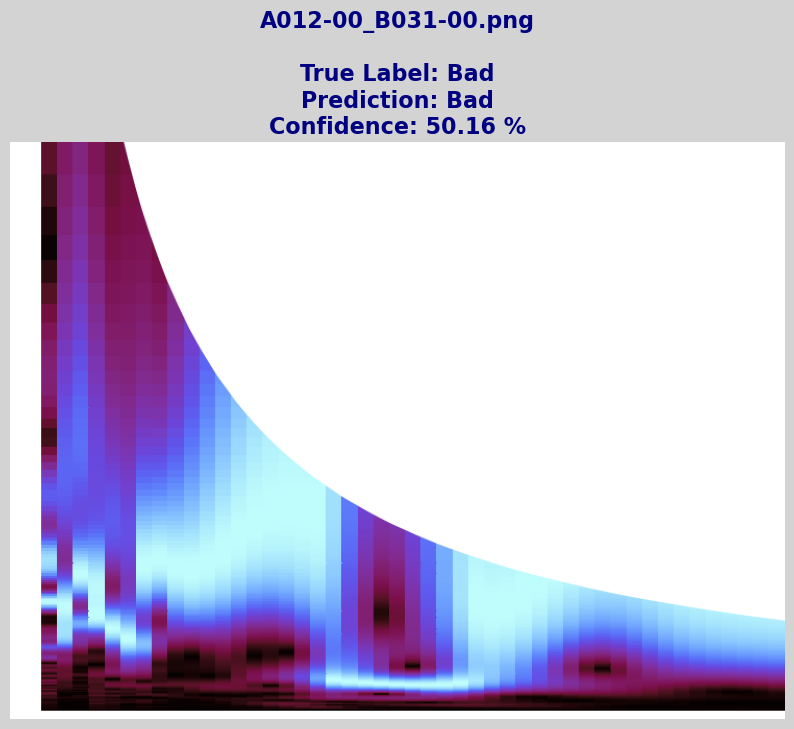

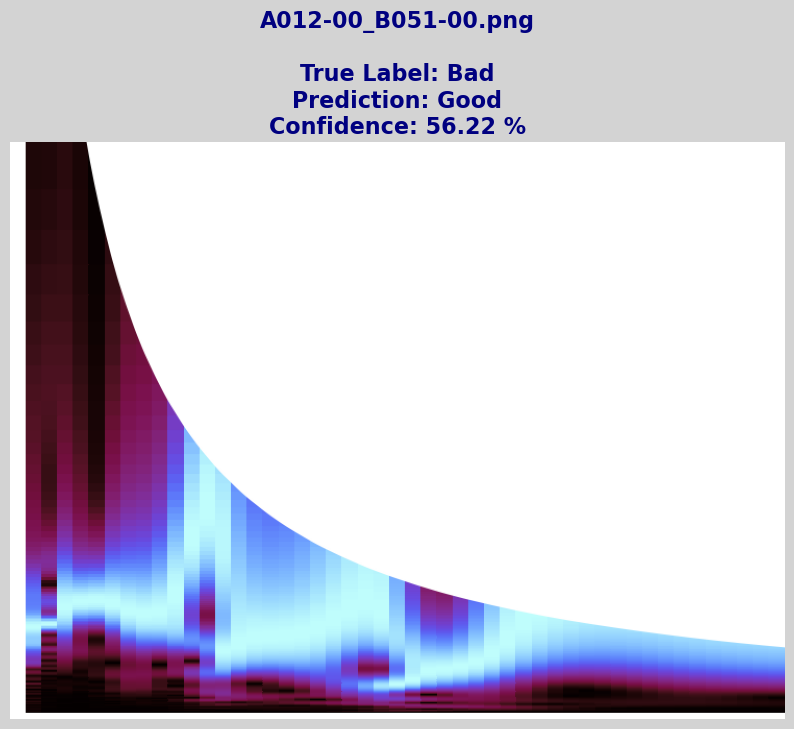

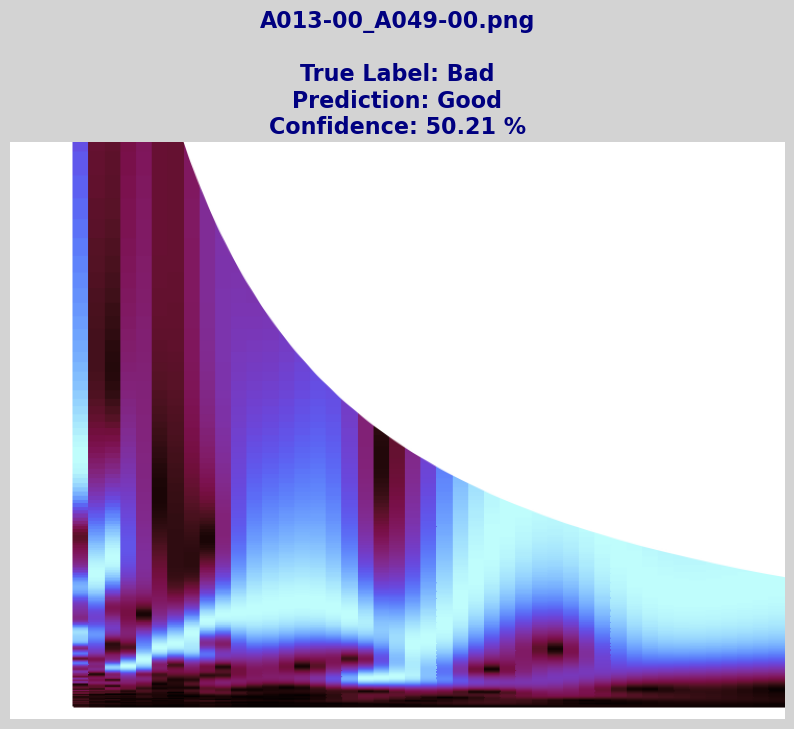

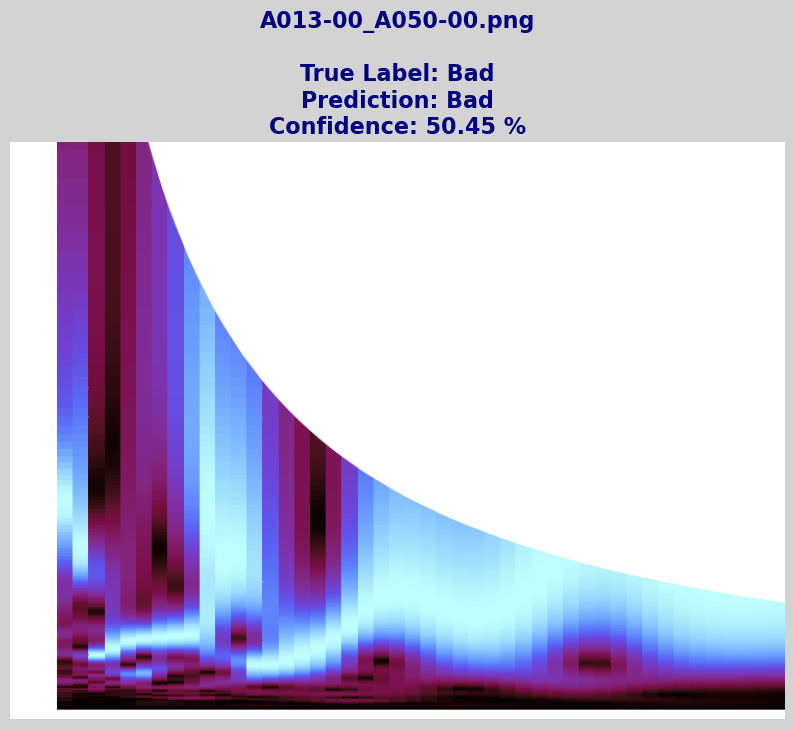

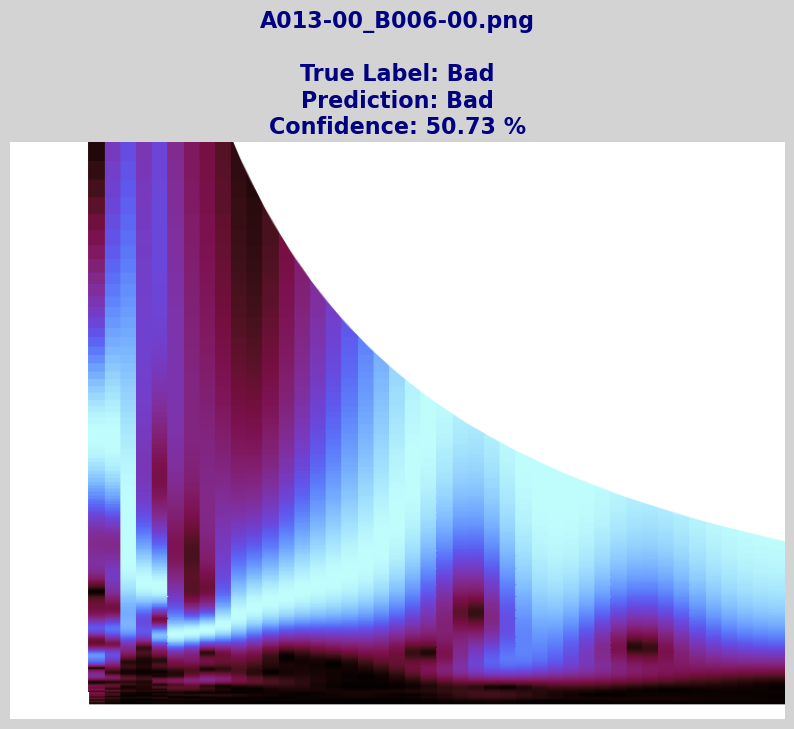

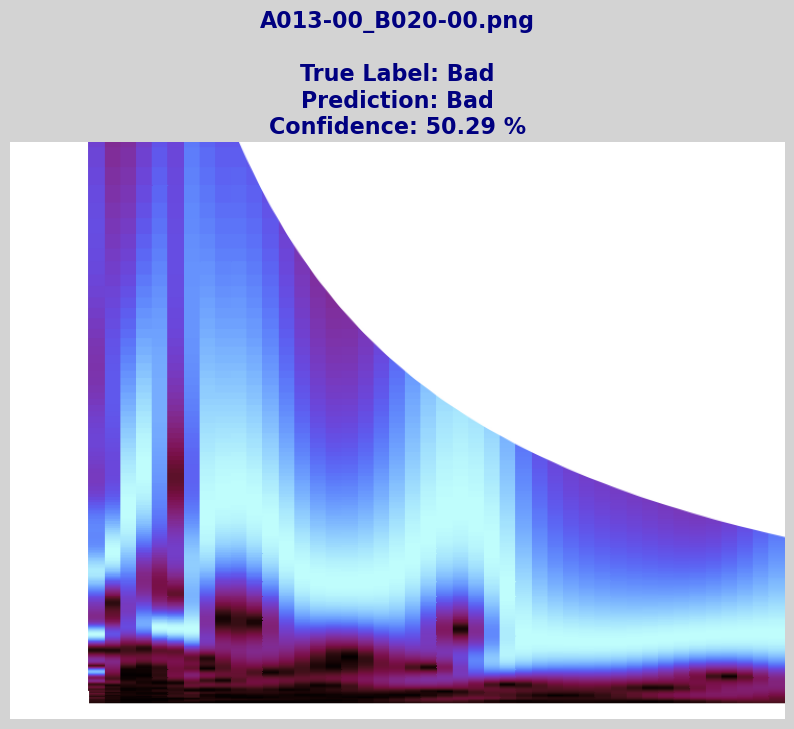

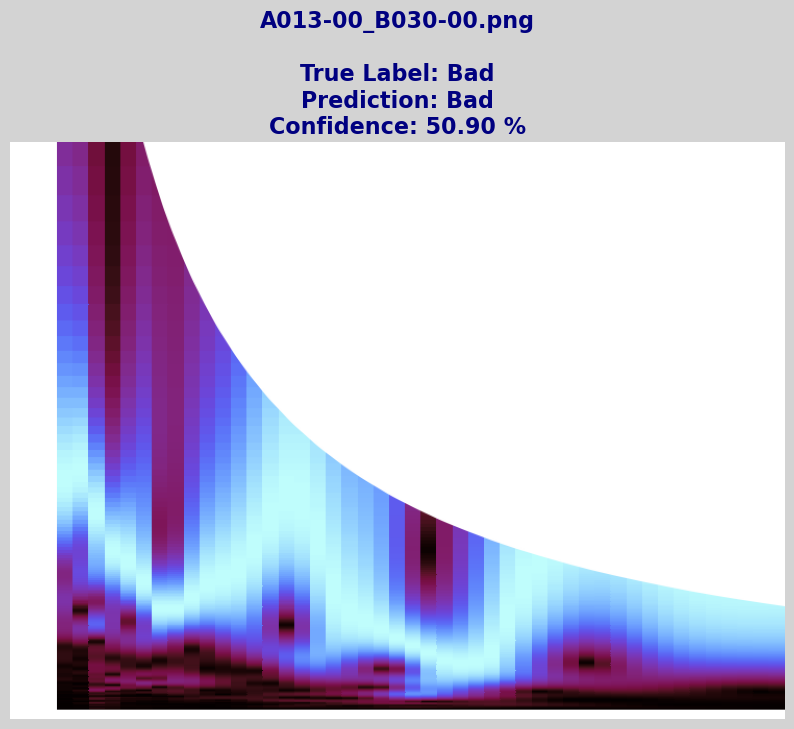

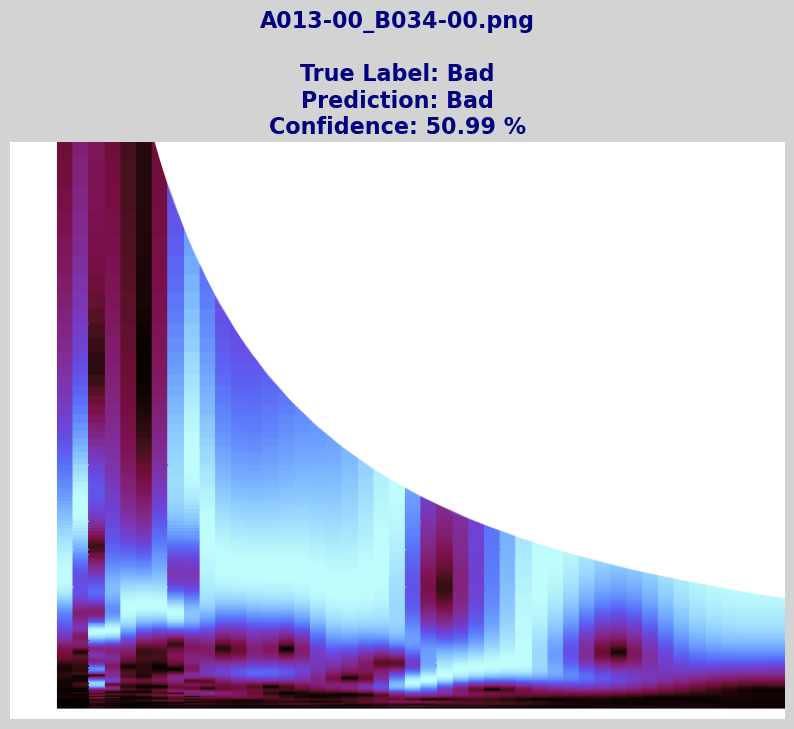

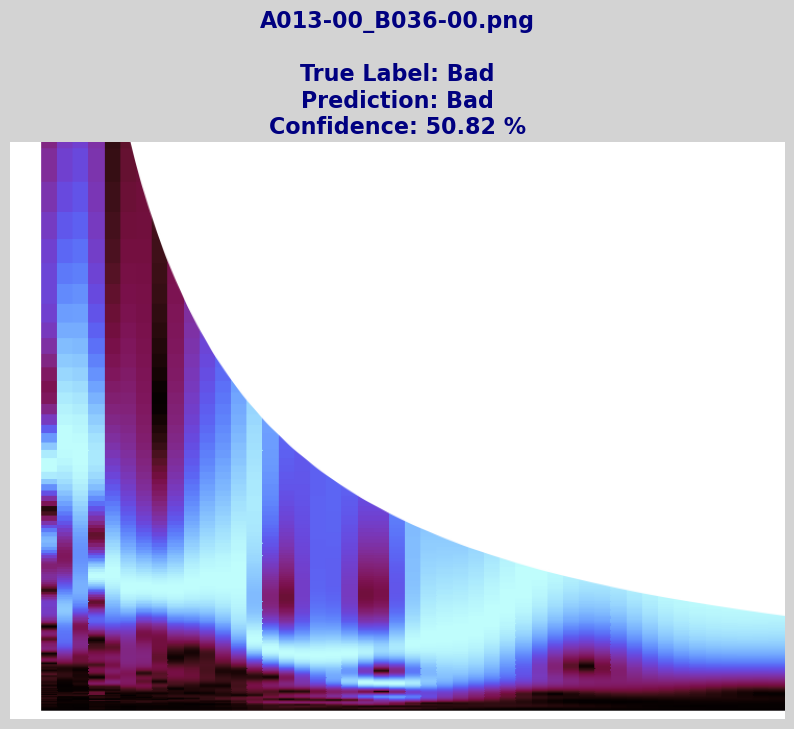

In [43]:
plot_data = {'img_path': img_path_test,
             'true_label': np.where(y_test==0, 'Bad', 'Good'),
             'pred_label': np.where(y_test_pred==0, 'Bad', 'Good'),
             'pred_confidence': np.max(confidence, axis=1)
            }

df = pd.DataFrame(plot_data)

# Reset the DataFrame's index
df = df.reset_index(drop=True)

# Create a new directory for the results
os.makedirs('results_viz', exist_ok=True)


for i, row in df.iterrows():
    img_path, true_label, pred_label, pred_confidence = row['img_path'], row['true_label'], row['pred_label'], row['pred_confidence']
    
    # Read the image
    img = cv2.imread(img_path)
    
    # Create a new figure for each image
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Display the image
    ax.imshow(img)
    ax.axis('off')
    
    # Set the title and adjust its appearance
    title_text = f"{os.path.basename(img_path)}\n\nTrue Label: {true_label}\nPrediction: {pred_label}\nConfidence: {100*pred_confidence:.2f} %"
    ax.set_title(title_text, fontsize=16, fontweight='bold', color='navy')
    
    # Set the background color of the plot to a light gray color
    fig.patch.set_facecolor('lightgray')

    # Save the plot
    #plt.savefig(f'results_viz/{os.path.basename(img_path)}')
    
    # Close the plot to free up memory
    #plt.close(fig)

    # Show the plot
    plt.show()



In conclusion, the suggested approach for the binary image classification based on the statistics recovered from the images showed its efficiency with the accuracy of 70% on the test dataset. Nevertheless, another approach, using convolutional neural networks could be used to achive better accuracy and confidence score.  